In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import networkx as nx
from matplotlib.colors import LogNorm
import unidecode

import matplotlib as mpl
font = {        'size'   : 15}
mpl.rc('font', **font)

from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
from scipy import stats

# Social Network Data

In [115]:
cities_final = pd.read_csv('../data/cities_final.csv')
cities_final.head()

invitations_iwiw = pd.read_csv('../data/invitation_counts.csv.gz')
invitations_iwiw.head()

,RegYear,CityId,InvitorCityId,w
0,2002,379,379,3809
1,2002,379,380,6
2,2002,379,381,7
3,2002,379,382,8
4,2002,379,383,12


In [116]:
# Getting the top 20 cities
iwiw_codes = [379, 380, 381, 382, 383, 384, 385, 386, 387, 388, 389, 390, 391, 392, 393, 394, 396, 1842, 2103]
iwiw_code_dict= {379: 'Budapest', 380: 'Debrecen', 381: 'Miskolc', 382: 'Szeged', 383: 'Pecs', 384: 'Gyor', 385: 'Nyiregyhaza', 386: 'Kecskemet',
 387: 'Szekesfehervar', 388: 'Szombathely', 389: 'Szolnok', 390: 'Tatabanya', 391: 'Kaposvar', 392: 'Bekescsaba', 393: 'Zalaegerszeg',
 394: 'Veszprem', 396: 'Eger', 1842: 'Szekszard', 2103: 'Salgotarjan'}
city_to_code = {v:k for k,v in iwiw_code_dict.items()}

In [117]:
mask1 = invitations_iwiw["CityId"].map(lambda i: i in iwiw_codes)
mask2 = invitations_iwiw["InvitorCityId"].map(lambda i: i in iwiw_codes)
mask3 = invitations_iwiw["InvitorCityId"]!=invitations_iwiw["CityId"]

# Edgelist with only the top 19
reduced_df = invitations_iwiw[mask1&mask2]
reduced_df.head()
# print(len(reduced_df['InvitorCityId'].unique()))

,RegYear,CityId,InvitorCityId,w
0,2002,379,379,3809
1,2002,379,380,6
2,2002,379,381,7
3,2002,379,382,8
4,2002,379,383,12


In [118]:
Years = list(reduced_df['RegYear'].unique())
Connections_list = [nx.to_numpy_array(nx.from_pandas_edgelist(reduced_df[reduced_df['RegYear']==year],
                                                        source='InvitorCityId',target='CityId',edge_attr='w',
                                                        create_using=nx.DiGraph),weight='w',dtype=int,nodelist=iwiw_codes)
             for year in Years]

# asymmetric, weighted tensor of size T x N x N
W = np.array(Connections_list)

# asymmetric, normalised tensor
W_norm = np.zeros_like(W,dtype='float64')
for t in range(W.shape[0]):
    W_norm[t,:,:] = W[t,:,:]
#     np.fill_diagonal(W_norm[t,:,:],0) # removing all self-loops
    W_norm[t,:,:] /= W_norm[t,:,:].sum()

In [119]:
# symmetrised, weighted social connection tensor S
S = np.cumsum(W + np.transpose(W,axes=[0,2,1]),axis=0)
# correcting the self loops since double counted
for i in range(S.shape[2]):
    S[:,i,i] = S[:,i,i]/2
    
mask_SL_t = ~np.eye(S.shape[1],dtype=bool) # mask for self loops in a snapshot
mask_SL = np.array([mask_SL_t]*11) # mask for self loops across all snapshots

## Visualisations of social network

In [7]:
# Visualising S_norm for each year
for t in range(S.shape[0]):
    plt.figure(figsize=(5,5))
    im=plt.imshow(S_norm[t,:,:],vmin=0,vmax=S_norm.max())
#                ,norm=LogNorm(vmin=S_norm[S_norm>0].min(),vmax=S_norm.max()))
    plt.colorbar(im)
    plt.title(Years[t])

NameError: name 'S_norm' is not defined

<Figure size 360x360 with 0 Axes>

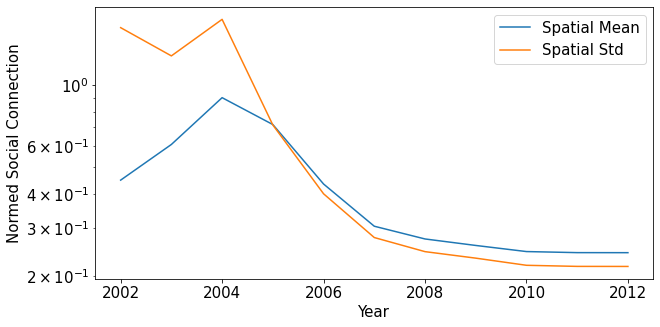

In [18]:
fig=plt.figure(figsize=(10,5))

plt.plot(Years,[S_norm[t,:,:].mean() for t in range(S.shape[0])],label='Spatial Mean')
# plt.plot(Years,[W_norm[t,:,:].mean() for t in range(S.shape[0])],label=r'$\bar{w} (t)$')

plt.plot(Years,[S_norm[t,:,:].std() for t in range(S.shape[0])],label='Spatial Std')
# plt.plot(Years,[W_norm[t,:,:].std() for t in range(S.shape[0])],label=r'$\sigma_w (t)$')
plt.legend()
plt.xlabel("Year")
plt.ylabel("Normed Social Connection")
plt.yscale('log')
# fig.savefig("Statistics of s_ij.png",bbox_inches='tight')

# Road Network Data
Will output a distance tensor $D$ of size $T \times N \times N$ that has units of km.

In [8]:
years_in_road_network = [2001,2003,2007,2008,2009,2011,2012]
year_to_road = {}

# producing a dictionary of {year:distance matrix of the year}
for year in years_in_road_network:
    df_distances = pd.read_excel('output-all.xlsx',sheet_name='pairs-'+str(year))
    # Removing accents
    df_distances[['From','To']] = df_distances[['From','To']].apply(lambda x: x.str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8'))
    # Replacing city names with ids
    df_distances=df_distances.replace({'From':city_to_code,'To':city_to_code})
    year_to_road[year]=nx.to_numpy_array(nx.from_pandas_edgelist(df_distances,
                                                        source='From',target='To',edge_attr='Distance',
                                                        create_using=nx.DiGraph),
                                            weight='Distance',dtype=int,nodelist=iwiw_codes)

# populating missing years with the last known data, e.g. if 2004 is missing then use 2003 data
dist_arr_list = []
last=years_in_road_network[0]
for year in Years:
    if year in years_in_road_network:
        dist_arr_list.append(year_to_road[year])
        last = year
    else:
        dist_arr_list.append(year_to_road[last])

# Final distance tensor D
D = np.array(dist_arr_list)/1000 # change to km

/home/jbara/anaconda3/lib/python3.7/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


## Visualisation of Road Network

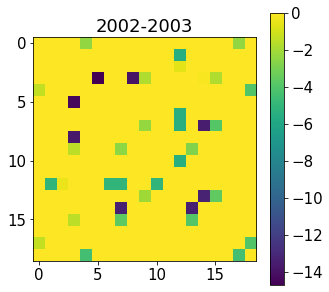

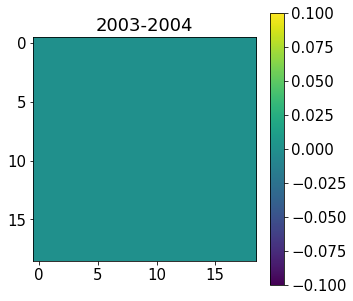

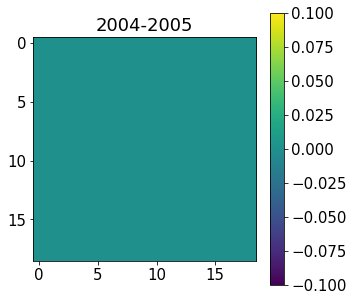

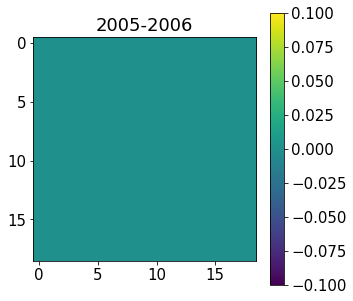

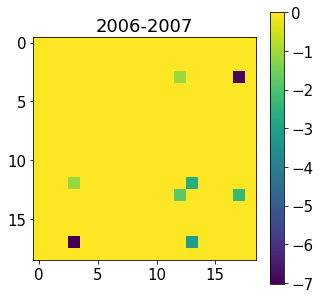

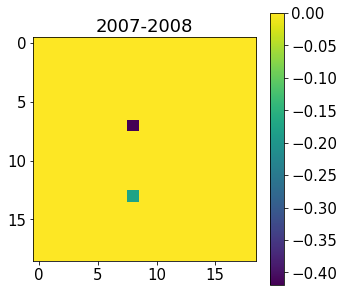

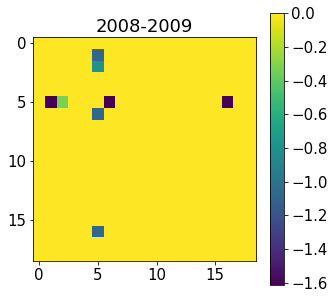

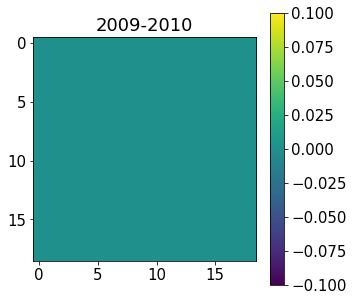

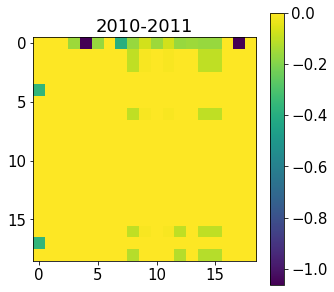

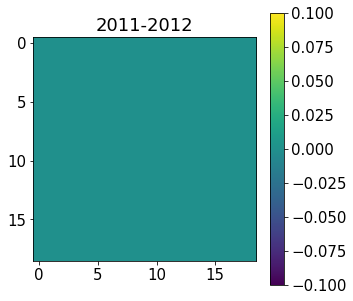

In [30]:
# Visualising S_norm for each year
for t in range(D.shape[0]-1):
    plt.figure(figsize=(5,5))
    im=plt.imshow(np.diff(D,axis=0)[t,:,:])#,
#                norm=LogNorm(vmin=D[D>0].min(),vmax=D.max()))
    plt.colorbar(im)
    title = str(Years[t])+'-'+str(Years[t+1])
    plt.title(title)
    plt.savefig('Figures/distance_changes_'+title+'.png',bbox_inches='tight')

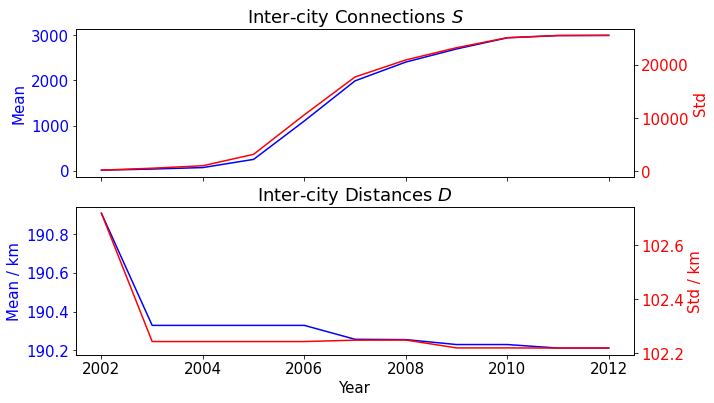

In [15]:
fig,axs=plt.subplots(figsize=(10,6),nrows=2,sharex=True)
axs[0].set_title(r"Inter-city Connections $S$")
color='blue'
axs[0].plot(Years,[S[t,:,:].mean() for t in range(S.shape[0])],label='Mean',color=color)
axs[0].set_ylabel("Mean",color=color)
axs[0].tick_params(axis='y', labelcolor=color)

color = 'red'
ax2 = axs[0].twinx()
ax2.plot(Years,[S[t,:,:].std() for t in range(S.shape[0])],label='Std',color=color)
ax2.set_ylabel("Std",color=color)
ax2.tick_params(axis='y', labelcolor=color)


axs[1].set_title(r"Inter-city Distances $D$")
color='blue'
axs[1].plot(Years,[D[t,:,:].mean() for t in range(D.shape[0])],label='Mean',color=color)
axs[1].set_xlabel("Year")
axs[1].set_ylabel("Mean / km",color=color)
axs[1].tick_params(axis='y', labelcolor=color)

color = 'red'
ax3 = axs[1].twinx()
ax3.plot(Years,[D[t,:,:].std() for t in range(D.shape[0])],label='Std',color=color)
ax3.set_ylabel("Std / km",color=color)
ax3.tick_params(axis='y', labelcolor=color)

# plt.legend()

# plt.yscale('log')
fig.savefig("Figures/Inter-city connections and distances.pdf",bbox_inches='tight')

# Road Network Data
Will output a distance tensor $D$ of size $T \times N \times N$ that has units of km.

In [9]:
def lag_corr(A,B,t,tau,self_loops=True):
    # A and B must be tensors with time on axis 0, the rest of the dimensions must be the same
    if t >= A.shape[0] or t+tau>=B.shape[0]:
        return 0
    elif self_loops:
        return np.corrcoef(A[t,:,:].flatten(),B[t+tau,:,:].flatten())[0,1]
    else:
        mask = ~np.eye(A.shape[-1],dtype=bool)
#         A_t = A[t,:,:]
#         B_ttau = B[t+tau,:,:]
#         A_t=A_t[~np.eye(A_t.shape[0],dtype=bool)].reshape(A_t.shape[0],-1)
#         B_ttau=B_ttau[~np.eye(B_ttau.shape[0],dtype=bool)].reshape(B_ttau.shape[0],-1)
        return np.corrcoef(A[t,:,:][mask],B[t+tau,:,:][mask])[0,1]

# producing a dictionary of {year:distance matrix of the year}
for year in years_in_road_network:
    df_distances = pd.read_excel('output-all.xlsx',sheet_name='pairs-'+str(year))
    # Removing accents
    df_distances[['From','To']] = df_distances[['From','To']].apply(lambda x: x.str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8'))
    # Replacing city names with ids
    df_distances=df_distances.replace({'From':city_to_code,'To':city_to_code})
    year_to_road[year]=nx.to_numpy_array(nx.from_pandas_edgelist(df_distances,
                                                        source='From',target='To',edge_attr='Distance',
                                                        create_using=nx.DiGraph),
                                            weight='Distance',dtype=int,nodelist=iwiw_codes)

def per_user_probability(D,S,n,d_min,d_max,bar=False):
    # outputs the per-user probability at time t for conncections between distance [d_min,d_max)
        # D - distance tensor T x N x N
        # S - symmetrised connection tensor T x N x N
        # n - number of users matrix T x N
        # [d_min,d_max) interval for distances
    if not bar:
        s = np.zeros(S.shape[0])
        s_p = np.zeros(S.shape[0])
        for t in range(S.shape[0]):
            mask = (D[t,:,:]>=d_min)&(D[t,:,:]<d_max)
            s[t] = np.triu(S[t,:,:]*mask).sum()
            s_p[t] = (np.outer(n[t,:],n[t,:])*mask).sum()
        return s.sum()/s_p.sum()
    else:
        return np.mean([per_user_probability_t(D,S,n,d_min,d_max,t) for t in range(D.shape[0])])
    
# Wrappers while we don't yet have D
def lag_corr_matrix(A,B,self_loops=True):
    rho = np.zeros([A.shape[0],B.shape[0]])
    for t in range(A.shape[0]):
        for tau in range(B.shape[0]):
            rho[t,tau] = lag_corr(A,B,t,tau,self_loops=self_loops)
    return rho

def maximal_lag_corr(A,B):
    return np.min(lag_corr_matrix(A,B),axis=1)

def char_timescales(A,B):
    return np.argmin(lag_corr_matrix(A,B),axis=1)

# Null Models

In [120]:
# Null Model 1 - Random Graph
S_ti = np.sum(S,axis=2)
S_null_random = np.zeros_like(S,dtype='float64')
for t in range(S.shape[0]):
    S_null_random[t,:,:] = np.outer(S_ti[t,:],S_ti[t,:]) / np.sum(S[t,:,:])
    

# Null Model 2 - Gravity Model
    # requires the distance tensor too!
S_null_gravity = np.zeros_like(S,dtype='float64')
    #exponents:
alpha = 1
beta = 1
gamma = 2
n=users_per_city(W) # natively two cities have 0 users to begin with
for t in range(S.shape[0]):
    S_null_gravity[t,:,:] = np.outer(n[t,:]**alpha,n[t,:]**beta)/D[t,:,:]**gamma
    

# Null Model 3 - Radiation Model
S_null_radiation = np.zeros_like(S,dtype='float64')
m = np.zeros_like(S)
for t in range(S.shape[0]):
    for i in range(S.shape[1]):
        for j in range(S.shape[2]):
            for k in range(S.shape[2]):
                if D[t,i,k] <= D[t,i,j]:
                    m[t,i,j] += n[t,k]
    for i in range(S.shape[1]):
        for j in range(S.shape[2]):
            S_null_radiation[t,i,j] = S_ti[t,i]*n[t,i]*n[t,j]/((n[t,i]+n[t,j]+m[t,i,j])*(n[t,i]+m[t,i,j]))

/home/jbara/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in true_divide


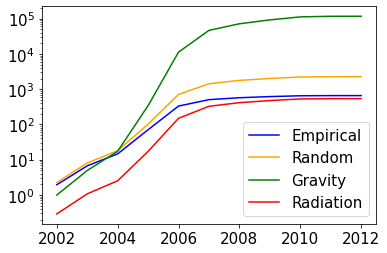

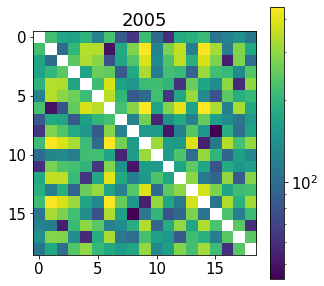

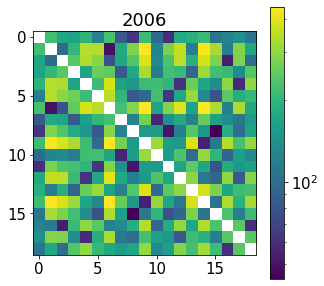

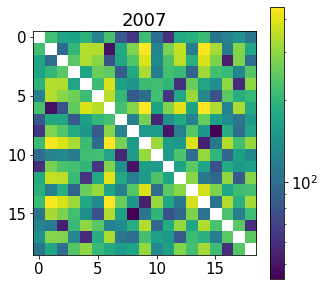

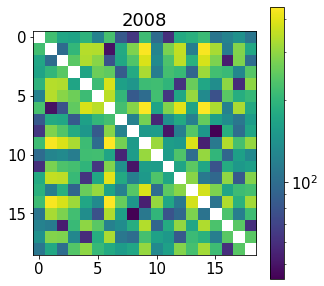

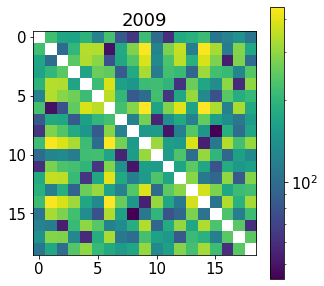

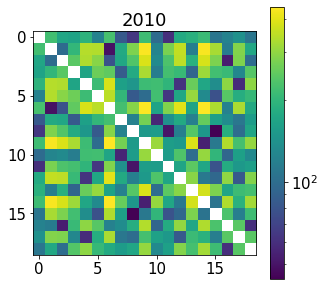

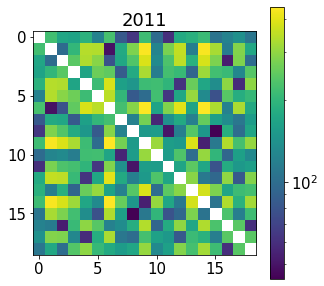

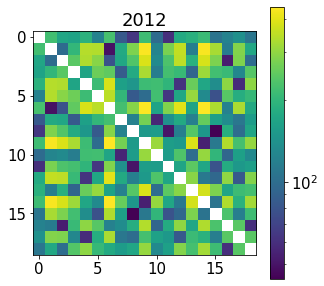

In [126]:
colors = ['orange','g','red']
# With self loops
# plt.plot(Years,S.mean(axis=(1,2)),color='b',label='Empirical')
# plt.plot(Years,S_null_random.mean(axis=(1,2)),color=colors[0],label='Random')
# plt.plot(Years,S_null_gravity.mean(axis=(1,2)),color=colors[1],label='Gravity')
# plt.plot(Years,S_null_radiation.mean(axis=(1,2)),color=colors[2],label='Radiation')

# removing self-loops
plt.plot(Years,[S[t,:,:][mask_SL_t].mean() for t in range(S.shape[0])],color='b',label='Empirical')
plt.plot(Years,[S_null_random[t,:,:][mask_SL_t].mean() for t in range(S.shape[0])],color=colors[0],label='Random')
plt.plot(Years,[S_null_gravity[t,:,:][mask_SL_t].mean() for t in range(S.shape[0])],color=colors[1],label='Gravity')
plt.plot(Years,[S_null_radiation[t,:,:][mask_SL_t].mean() for t in range(S.shape[0])],color=colors[2],label='Radiation')
plt.yscale('log')

plt.legend()

In [11]:
# symmetrised, social connection tensor S_norm normalised to the null model
S_norm = S/S_null_random
for t in range(11):
    np.fill_diagonal(S_norm[t,:,:],0)
    
S_norm_g = S/S_null_gravity
for t in range(11):
    np.fill_diagonal(S_norm_g[t,:,:],0)
    
S_norm_r = S/S_null_radiation
for t in range(11):
    np.fill_diagonal(S_norm_r[t,:,:],0)

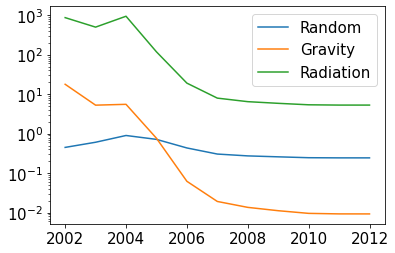

In [83]:
# With self loops
plt.plot(Years,S_norm.mean(axis=(1,2)),label='Random')
plt.plot(Years,S_norm_g.mean(axis=(1,2)),label='Gravity')
plt.plot(Years,S_norm_r.mean(axis=(1,2)),label='Radiation')

# Without self loops
# plt.plot(Years,[S_norm[t,:,:][mask_SL_t].mean() for t in range(S.shape[0])],label='Random')
# plt.plot(Years,[S_norm_g[t,:,:][mask_SL_t].mean() for t in range(S.shape[0])],label='Gravity')
# plt.plot(Years,[S_norm_r[t,:,:][mask_SL_t].mean() for t in range(S.shape[0])],label='Radiation')

plt.legend()
plt.yscale('log')

## regressions

## a) Lagged correlation

Text(0, 0.5, 'Lag $\\tau$')

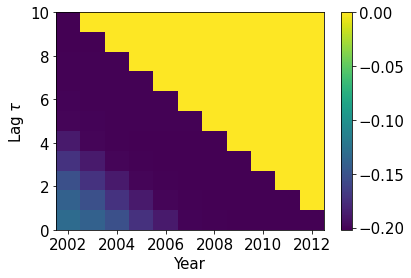

In [20]:
rho = lag_corr_matrix(D,S,self_loops=False)
plt.imshow(rho,extent=[2001.5,2012.5,0,10],aspect='auto',origin='lower')
plt.xticks(ticks=range(2002,2014,2),labels=range(2002,2014,2))
plt.colorbar()
plt.xlabel("Year")
plt.ylabel(r"Lag $\tau$")

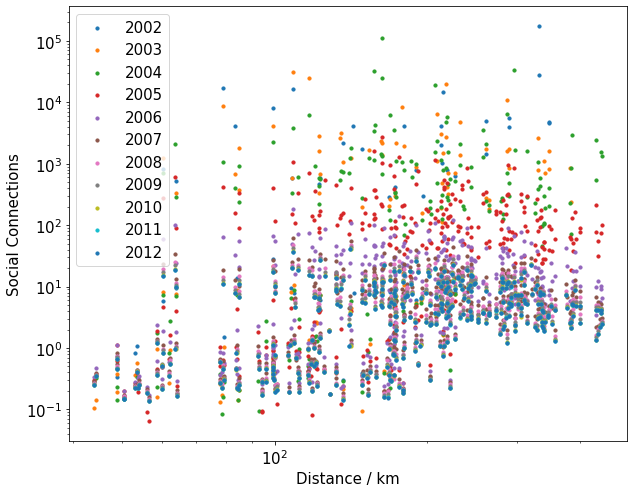

In [73]:
fig=plt.figure(figsize=(10,8))
for t in range(D.shape[0]):
    plt.scatter(D[t,:,:][mask_SL_t],S_norm_r[t,:,:][mask_SL_t],
                label=Years[t],s=10)
plt.legend()
plt.xlabel("Distance / km")
plt.ylabel("Social Connections")
plt.yscale('log')
plt.xscale('log')
# plt.ylim([1e-3,1e2])

## Ranks

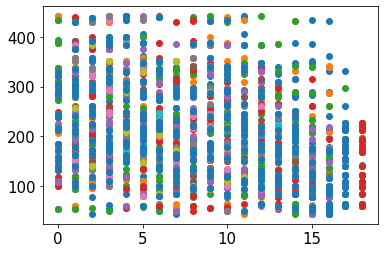

In [74]:
S_ranks = S.argsort(axis=2).argsort(axis=2)
D_ranks = 18-D.argsort(axis=2).argsort(axis=2)
for t in range(S.shape[0]):
    plt.scatter(S_ranks[t,:,:][mask_SL_t],D[t,:,:][mask_SL_t])

In [ ]:
plt.scatter(D_ranks[-1,:,:],S_ranks[-1,:,:])
print(np.corrcoef(D_ranks[-1,:,:].flatten(),S_ranks[-1,:,:].flatten()))

# Outliers
Looking at edges where the distance has significantly changed and focusing on them.

In [97]:
deltaD = np.diff(D,axis=0)
ind_min = np.unravel_index(np.argmin(deltaD),deltaD.shape)
max_change_edge = iwiw_code_dict[iwiw_codes[ind_min[1]]] + ' to ' + iwiw_code_dict[iwiw_codes[ind_min[2]]]
print(max_change_edge)

Szeged to Gyor


In [102]:
print(deltaD[0,:,:])

[[  0.      0.      0.      0.     -2.37    0.      0.      0.      0.
    0.      0.      0.      0.      0.      0.      0.      0.     -2.37
    0.   ]
 [  0.      0.      0.      0.      0.      0.      0.      0.      0.
    0.      0.      0.     -5.425   0.      0.      0.      0.      0.
    0.   ]
 [  0.      0.      0.      0.      0.      0.      0.      0.      0.
    0.      0.      0.     -0.59    0.      0.      0.      0.      0.
    0.   ]
 [  0.      0.      0.      0.      0.    -14.682   0.      0.    -13.884
   -1.727   0.      0.      0.      0.     -0.169  -1.727   0.      0.
    0.   ]
 [ -1.359   0.      0.      0.      0.      0.      0.      0.      0.
    0.      0.      0.      0.      0.      0.      0.      0.      0.
   -4.011]
 [  0.      0.      0.    -14.371   0.      0.      0.      0.      0.
    0.      0.      0.      0.      0.      0.      0.      0.      0.
    0.   ]
 [  0.      0.      0.      0.      0.      0.      0.      0.      0.
    0.

In [105]:
Top_by_eye=[(0,3,5),(0,3,8),(0,7,14),(4,3,17),(4,17,13)]
Top_as_cities = [(iwiw_code_dict[iwiw_codes[x]],iwiw_code_dict[iwiw_codes[y]]) for t,x,y in Top_by_eye]
print(Top_as_cities)

[('Szeged', 'Gyor'), ('Szeged', 'Szekesfehervar'), ('Kecskemet', 'Zalaegerszeg'), ('Szeged', 'Szekszard'), ('Szekszard', 'Bekescsaba')]


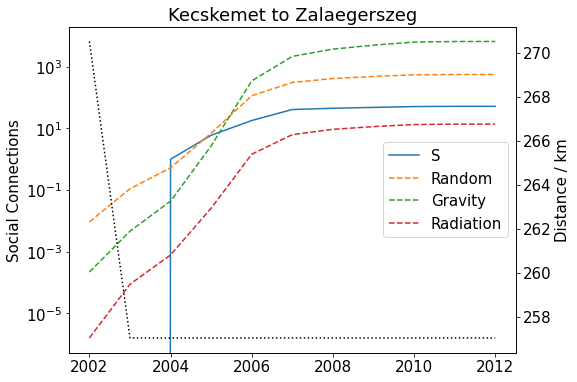

In [107]:
fig,ax=plt.subplots(figsize=(8,6))
i = 2
mask = (range(S.shape[0]),Top_by_eye[i][1],Top_by_eye[i][2])
ax.set_title(Top_as_cities[i][0]+' to ' + Top_as_cities[i][1])
ax.plot(Years,S[mask],label='S')
ax.plot(Years,S_null_random[mask],'--',label='Random')
ax.plot(Years,S_null_gravity[mask],'--',label='Gravity')
ax.plot(Years,S_null_radiation[mask],'--',label='Radiation')
ax.set_ylabel("Social Connections")
ax.set_yscale('log')
# ax.xlim([2003,2012.5])

ax2=ax.twinx()
ax2.plot(Years,D[mask],color='k',ls=':')
ax2.set_ylabel("Distance / km")

ax.legend(loc='right')

# Null Models

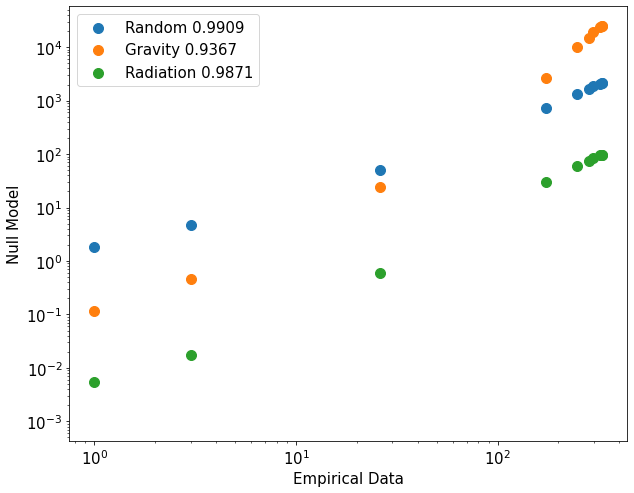

In [101]:
mask = (range(S.shape[0]),ind_min[1],ind_min[2])
r_random = stats.pearsonr(S[mask],S_null_random[mask])
r_gravity = stats.pearsonr(S[mask],S_null_gravity[mask])
r_radiation = stats.pearsonr(S[mask],S_null_radiation[mask])


fig=plt.figure(figsize=(10,8))
plt.scatter(S[mask],S_null_random[mask],s=100,label='Random %.4f'%r_random[0])
plt.scatter(S[mask],S_null_gravity[mask],s=100,label='Gravity %.4f'%r_gravity[0])
plt.scatter(S[mask],S_null_radiation[mask],s=100,label='Radiation %.4f'%r_radiation[0])
plt.yscale('log')
plt.ylabel("Null Model")
plt.xscale('log')
plt.xlabel("Empirical Data")
plt.legend()

# Potential analysis
$D$ can be the tensor of either spatial distances or travel times

$P(d)$ needs to be properly normalised to get a distribution in distances hence have a $\tilde{P}(d) \propto P(d)$ such that $\int \tilde{P}(x) dx= 1$.

In [35]:
# Correctly normalised (i.e. sum to 1) distance distribution P_tilde(d)
def distance_distribution(D,S,n,bins=50,bar=False,t=None):
    # If t = None, will use P(d), otherwise if t is specified will use P(d,t)
    
    # bins can be either int or array
    if type(bins)==int:
        bins = np.linspace(D.min(),D.max()+1,num=bins)
    if t==None:
        P_tilde = [per_user_probability(D,S,n,bins[i],bins[i+1],bar=bar) for i in range(len(bins)-1)]
    else:
        P_tilde = [per_user_probability_t(D,S,n,bins[i],bins[i+1],t) for i in range(len(bins)-1)]
    return P_tilde/np.sum(P_tilde)#,bins

In [42]:
T = np.arange(2002,2013)
# d = np.linspace(D.min(),D.max()+1,num=bins)
d = np.arange(0,5.5e5,5e4)/1000
# bins = 10
s = np.zeros([11,len(d)-1])
s_p = np.zeros([11,len(d)-1])

for t,tp in enumerate(T):
    for d_ind,d_val in enumerate(d[:-1]):
        mask = (D[t,:,:]>=d[d_ind])&(D[t,:,:]<d[d_ind+1])
#         s[t,d_ind] = np.triu(S[t,:,:]*mask).sum()
        s[t,d_ind] = np.triu(S_norm[t,:,:]*mask).sum()
        s_p[t,d_ind] = (np.outer(n[t,:],n[t,:])*mask).sum()

/home/jbara/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


Text(0, 0.5, 'Year')

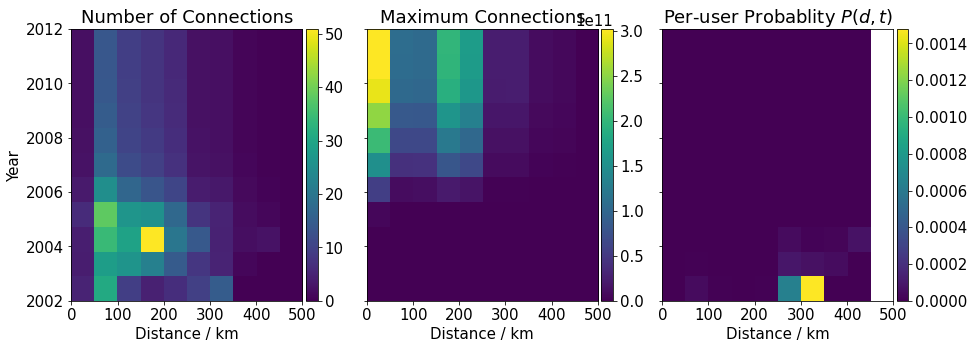

In [52]:
fig,axs = plt.subplots(figsize=(15,5),ncols=3,sharey=True)
szzz = [s,s_p,s/s_p]
labels = ['Number of Connections','Maximum Connections','Per-user Probablity $P(d,t)$']

# print(d)
for i in range(2):
    im = axs[i].imshow(szzz[i],
                       extent=[min(d),max(d),2002,2012],
                       aspect='auto',origin='lower'
#                        ,norm=LogNorm(vmin=1,
#                                     vmax=np.max(szzz[i]))
                      )
#     axs[i].set_colorbar(im)
    axs[i].set_xlabel('Distance / km')
    divider = make_axes_locatable(axs[i])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical')
    axs[i].set_title(labels[i])
for i in range(2,3):
    im = axs[i].imshow(szzz[i],
                       extent=[min(d),max(d),2002,2012],
                       aspect='auto',origin='lower'
#                        ,norm=LogNorm(vmin=1e-8,
#                                     vmax=np.max(szzz[i]))
                      )
#     axs[i].set_colorbar(im)
    axs[i].set_xlabel('Distance / km')
    divider = make_axes_locatable(axs[i])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical')
    axs[i].set_title(labels[i])
axs[0].set_ylabel('Year')

# fig.savefig("Per User Probability s=S_norm_withloops,finer bins.png",bbox_inches='tight')

/home/jbara/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in double_scalars


Text(0.5, 1.0, 'Per-user Probablity $P(d,t)$')

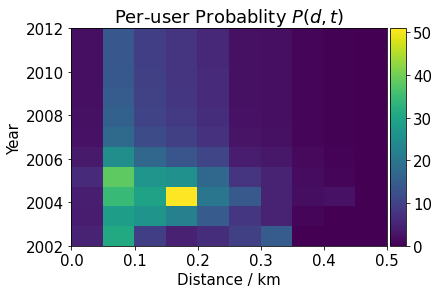

In [54]:
fig,ax = plt.subplots()
im = ax.imshow(s,
                    extent=[min(d)/1000,max(d)/1000,2002,2012],
                    aspect='auto',origin='lower')
#     axs[i].set_colorbar(im)
ax.set_ylabel('Year')
ax.set_xlabel('Distance / km')
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')
ax.set_title(labels[i])

# fig.savefig("s_tilde heatmap.png", bbox_inches='tight')

/home/jbara/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in double_scalars


Text(0.5, 1.0, 'Per-User Distance Distribution $P(d)$')

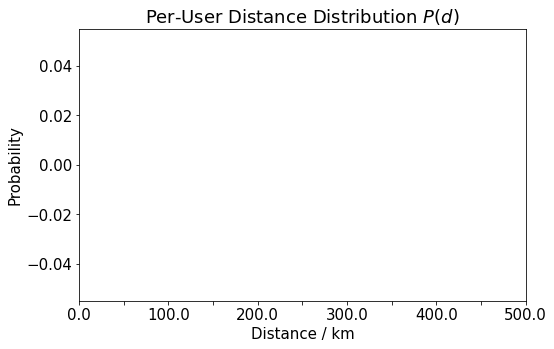

In [60]:
P = distance_distribution(D,S,n,bins=d,bar=False)
d_centre = [d[i]+d[i+1] for i in range(len(d)-1)]
d_ind = [i for i,_ in enumerate(d_centre)]
d_label = list(d)
for i in range(1,11,2):
    d_label[i] = ''

fig=plt.figure(figsize=(8,5))
plt.bar(d_ind,P,width=1)
plt.xticks([i-0.5 for i,_ in enumerate(d)], d_label);

plt.ylabel("Probability")
plt.xlabel("Distance / km")
plt.title("Per-User Distance Distribution $P(d)$")

# fig.savefig("Distance Distribution.png",bbox_inches='tight')

Text(0, 0.5, '$\\tilde{s}(d)$')

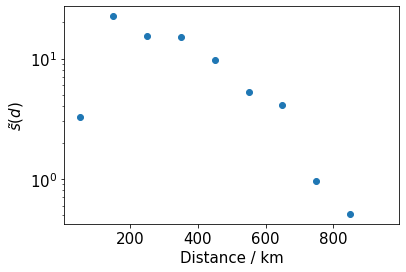

In [61]:
fig = plt.figure()
plt.scatter(np.array(d_centre),np.mean(s,axis=0))
# fig.savefig("temporal mean.png",bbox_inches='tight')
plt.yscale('log')
plt.xlabel("Distance / km")
plt.ylabel(r'$\tilde{s}(d)$')

# fig.savefig("temporal mean for s_null with self loops.png",bbox_inches='tight')